In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st

In [4]:
from utilities import *

In [5]:
import functools

In [6]:
%matplotlib inline
plt.ioff()
sns.set()
pd.set_option('display.max_columns', 100)

# Part 1: Load the Data

In [7]:
def load_data():    
    df = pd.read_csv('dataset.csv')
    df.set_index(['class', 'id_student'],inplace = True)
    return df

In [8]:
df = load_data()

In [9]:
df.head()

code_module code_presentation  date_registration  \
class    id_student                                                    
AAA2013J 11391              AAA             2013J             -159.0   
         28400              AAA             2013J              -53.0   
         31604              AAA             2013J              -52.0   
         32885              AAA             2013J             -176.0   
         38053              AAA             2013J             -110.0   

                     grade_Assessment  grade_Exam gender  \
class    id_student                                        
AAA2013J 11391                   82.4         NaN      M   
         28400                   65.4         NaN      F   
         31604                   76.3         NaN      F   
         32885                   55.0         NaN      F   
         38053                   66.9         NaN      M   

                         highest_education  imd_band age_band  \
class    id_student                                             
AAA2013J 11391            HE Qualification      95.0     55<=   
         28400            HE Qualification      25.0    35-55   
         31604       A Level or Equivalent      55.0    35-55   
         32885          Lower Than A Level      55.0     0-35   
         38053       A Level or Equivalent      85.0    35-55   

                     num_of_prev_attempts  studied_credits disability  \
class    id_student                                                     
AAA2013J 11391                          0              240          N   
         28400                          0               60          N   
         31604                          0               60          N   
         32885                          0               60          N   
         38053                          0               60          N   

                     activity_skew  attention_chi_sq_gof  \
class    id_student                                        
AAA2013J 11391            0.741381              2.736682   
         28400            0.334122              0.763697   
         31604            0.256927              0.327877   
         32885            0.849391              2.519574   
         38053           -0.008823              0.338421   

                     attention_hellinger_squared  attention_total_variation  \
class    id_student                                                           
AAA2013J 11391                          0.385076                   0.401765   
         28400                          0.151137                   0.255698   
         31604                          0.124606                   0.200600   
         32885                          0.361038                   0.403652   
         38053                          0.098247                   0.195052   

                     clicks_dataplus  clicks_dualpane  clicks_externalquiz  \
class    id_student                                                          
AAA2013J 11391                   0.0              0.0                  0.0   
         28400                  10.0              0.0                  0.0   
         31604                   2.0              0.0                  0.0   
         32885                   0.0              0.0                  0.0   
         38053                   7.0              0.0                  0.0   

                     clicks_folder  clicks_forumng  clicks_glossary  \
class    id_student                                                   
AAA2013J 11391                 0.0           193.0              0.0   
         28400                 0.0           417.0              0.0   
         31604                 0.0           634.0              1.0   
         32885                 0.0           194.0              4.0   
         38053                 0.0           875.0              4.0   

                     clicks_homepage  clicks_htmlactivity  \
class    id_student                          

In [10]:
y             = ['grade_Assessment', 'grade_Exam']
X_categorical = ['code_module', 'code_presentation', 'disability', 'gender', 'highest_education', 'age_band']
X_continuous  = df.columns.tolist()
for col in y + X_categorical:
    X_continuous.remove(col)

In [11]:
drop_by_rule(df, df.grade_Assessment.isna())

In [12]:
missing = df.isna().sum()
missing[missing != 0]

grade_Exam                      9006
imd_band                         659
mean_click_time_from_release    2362
mean_click_time_to_close        2362
dtype: int64

# Part 2: Look at the Data

## Compare to the DV

In [13]:
continuous_vars = FeaturePlot(df[X_continuous])

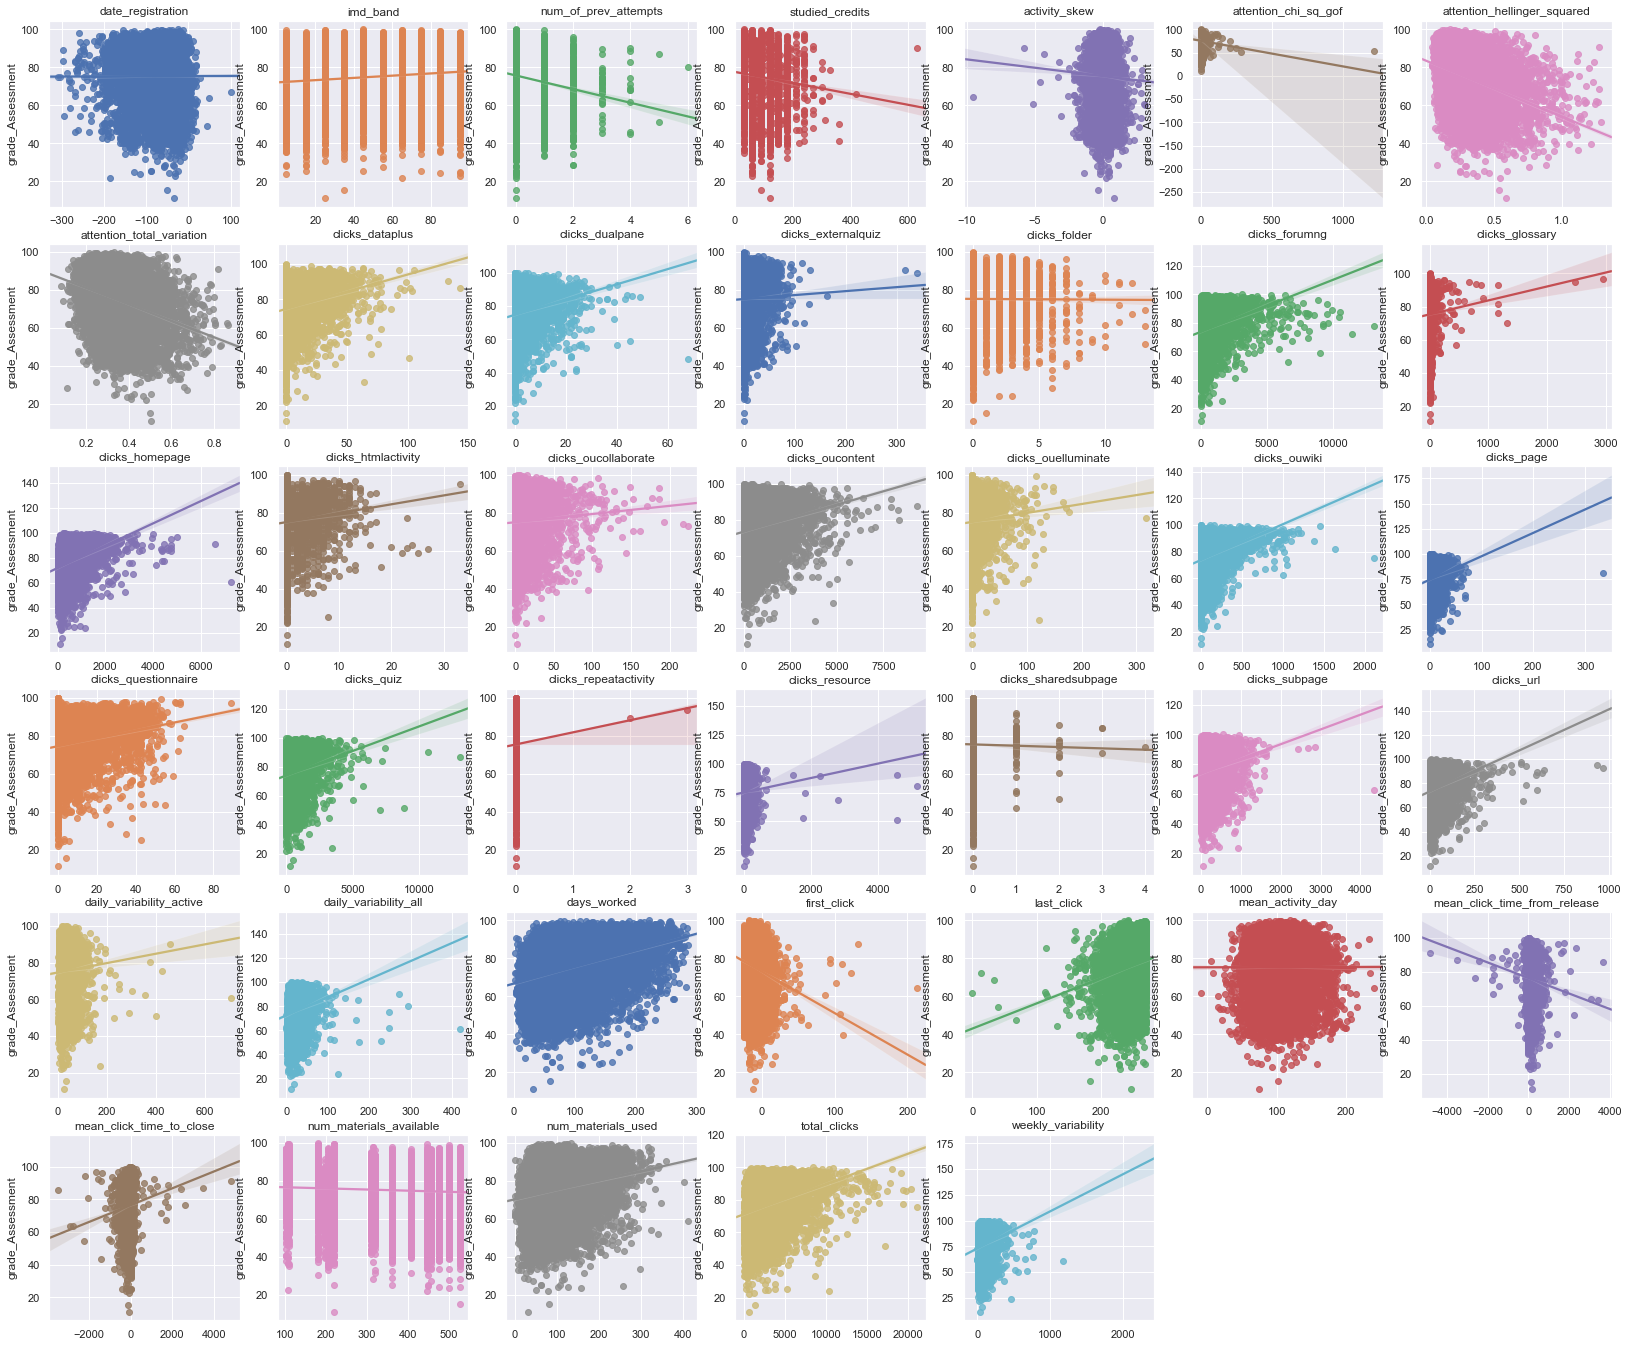

In [14]:
Timer.start()
for col_name, x, ax in continuous_vars:
    sns.regplot(x, df.grade_Assessment, x_ci = 95, ax = ax)

continuous_vars.fig

In [15]:
Timer.end()

48.115 seconds elapsed


In [16]:
categorical_variables = FeaturePlot(df[X_categorical])

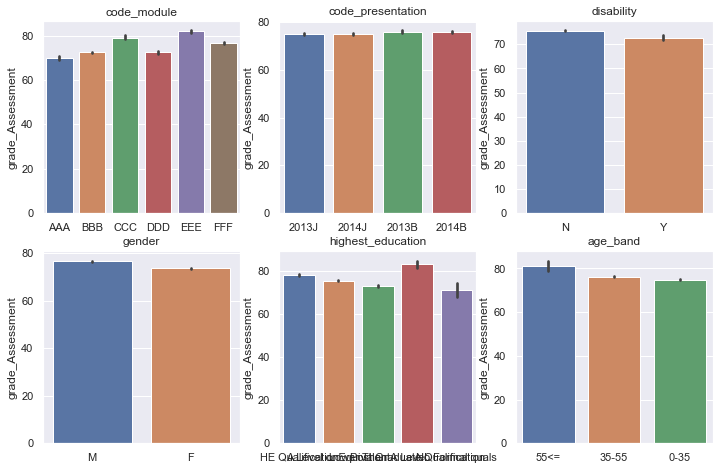

In [17]:
Timer.start()
for col_name, x, ax in categorical_variables:
    sns.barplot(x, df.grade_Assessment, ci = 95, ax = ax)

categorical_variables.fig

In [18]:
Timer.end()

2.831 seconds elapsed


In [19]:
results = []
for x in X_continuous:
    out_dict = {}
    data = df[[x, 'grade_Assessment']].dropna()
    r, p = st.pearsonr(data[x], data.grade_Assessment)
    out_dict['var'] = x
    out_dict['r'] = round(r, 3)
    out_dict['p'] = round(p, 3)
    out_dict['log_p'] = round(np.log(p)/np.log(10), 1)
    results.append(out_dict)

pearsonrs = pd.DataFrame.from_records(results).round(3)
pearsonrs.sort_values('log_p', inplace = True)

/Users/rcharan/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


In [20]:
pearsonrs

,var,r,p,log_p
30,days_worked,0.347,0.000,-inf
6,attention_hellinger_squared,-0.363,0.000,-inf
7,attention_total_variation,-0.330,0.000,-315.8
38,total_clicks,0.287,0.000,-236.0
14,clicks_homepage,0.260,0.000,-191.8
19,clicks_ouwiki,0.249,0.000,-176.1
37,num_materials_used,0.216,0.000,-131.0
27,clicks_url,0.212,0.000,-126.4
12,clicks_forumng,0.212,0.000,-125.9
17,clicks_oucontent,0.189,0.000,-100.6


## Look at distributions

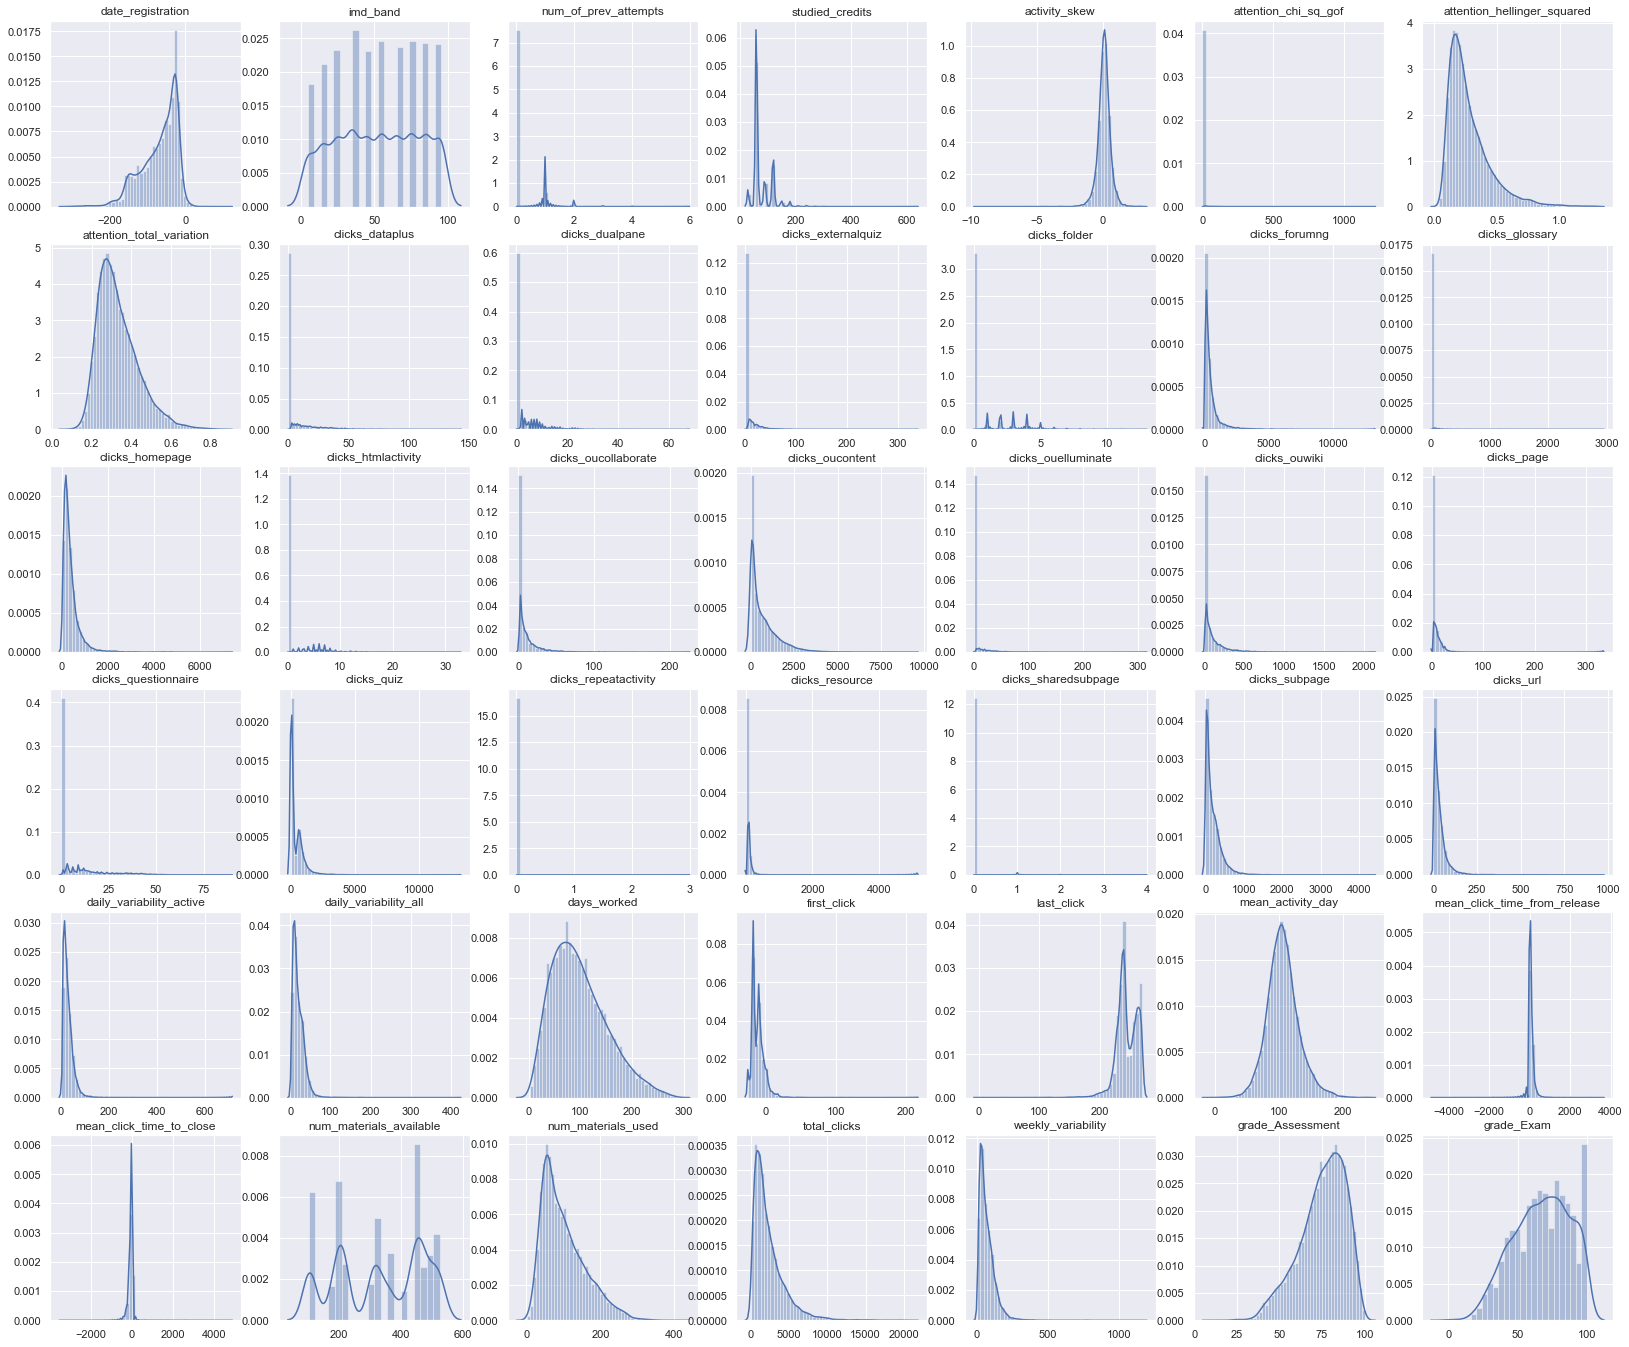

In [34]:
dists = FeaturePlot(df[X_continuous], df[y])

Timer.start()
for col_name, x, ax in dists:
    x = np.array(list(filter(lambda v : not pd.isnull(v), x)))
    sns.distplot(x, ax = ax)

dists.fig

In [35]:
Timer.end()

15.858 seconds elapsed


## TO DO: Correlation Matrix

# Part 3: Build a simple OLS model
 - First, run a regression with everything
 - Second, do a simple feature selection algorithm
 - Third, diagnose the resulting regression
 
No transformations of variables at this step

In [71]:
X_cont_model = X_continuous.copy()
X_cat_model  = list(map(lambda s : f'C({s})', X_categorical.copy()))
y_model      = 'grade_Assessment'
X_cont_model.remove('total_clicks') #Otherwise, multi-collinearity

In [72]:
def build_formula(cont, cat, y):
    return y + ' ~ ' + ' + '.join(cont + cat)

In [73]:
formula = build_formula(X_cont_model, X_cat_model, y_model)
results = smf.ols(formula, df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       grade_Assessment   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     74.38
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        17:55:52   Log-Likelihood:                -36702.
No. Observations:                9628   AIC:                         7.352e+04
Df Residuals:                    9572   BIC:                         7.392e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              53.8012      2.661     20.216      0.000      48.585      59.018
C(code_module)[T.BBB]                                   2.4211      0.723      3.349      0.001       1.004       3.838
C(code_module)[T.CCC]                                   8.2767      0.854      9.693      0.000       6.603       9.950
C(code_module)[T.DDD]                                  -9.0995      1.312     -6.936      0.000     -11.671      -6.528
C(code_module)[T.EEE]                                  13.1061      0.862     15.206      0.000      11.417      14.796
C(code_module)[T.FFF]                                 -11.5366      1.676     -6.884      0.000     -14.822      -8.252
C(code_presentation)[T.2013J]                           0.2237      0.740      0.302      0.763      -1.228       1.675
C(code_presentation)[T.2014B]                           1.5397      0.712      2.162      0.031       0.144       2.936
C(code_presentation)[T.2014J]                           1.6578      0.768      2.159      0.031       0.153       3.163
C(disability)[T.Y]                                     -1.7664      0.448     -3.943      0.000      -2.645      -0.888
C(gender)[T.M]                                          0.8270      0.300      2.752      0.006       0.238       1.416
C(highest_education)[T.HE Qualification]                0.8438      0.317      2.665      0.008       0.223       1.464
C(highest_education)[T.Lower Than A Level]             -3.0232      0.258    -11.708      0.000      -3.529      -2.517
C(highest_education)[T.No Formal quals]                -6.0670      1.707     -3.553      0.000      -9.414      -2.720
C(highest_education)[T.Post Graduate Qualification]     4.5967      1.252      3.671      0.000       2.142       7.051
C(age_band)[T.35-55]                                   -1.0002      0.260     -3.847      0.000      -1.510      -0.491
C(age_band)[T.55<=]                                    -0.4016      1.253     -0.320      0.749      -2.858       2.055
date_registration                                      -0.0010      0.002     -0.394      0.694      -0.006       0.004
imd_band                                                0.0409      0.004     10.058      0.000       0.033       0.049
num_of_prev_attempts                                   -1.1955      0.295     -4.058      0.000      -1.773      -0.618
studied_credits                                        -0.0120      0.003     -3.443      0.001      -0.019      -0.005
activity_skew                                          -1.8390      0.558     -3.294      0.001      -2.933      -0.745
attention_chi_sq_gof                                    0.0093      0.009      1.09

In [74]:
# Backwards stepwise regression, but only on the continuous variables
def backwards_stepwise(X_cont_model, X_cat_model, y_model):
    formula = build_formula(X_cont_model, X_cat_model, y_model)
    results = smf.ols(formula, df).fit()
    pvalues = results.pvalues
    def is_cont(var):
        return (not var.startswith('C(')) and (not var == 'Intercept')
    cont = list(filter(is_cont, results.pvalues.index))
    pvalues = pvalues[cont].sort_values(ascending = False)
    worst_p = pvalues[0]
    if worst_p >= 0.05:
        X_cont_model.remove(pvalues.index[0])
        return backwards_stepwise(X_cont_model, X_cat_model, y_model)
    else:
        return X_cont_model, X_cat_model, y_model, results

In [75]:
Timer.start()
_, _, _, results = backwards_stepwise(X_cont_model, X_cat_model, y_model)
Timer.end()

6.467 seconds elapsed


In [77]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       grade_Assessment   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     101.5
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        17:56:21   Log-Likelihood:                -36715.
No. Observations:                9628   AIC:                         7.351e+04
Df Residuals:                    9587   BIC:                         7.381e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              56.3150      1.659     33.942      0.000      53.063      59.567
C(code_module)[T.BBB]                                   2.3173      0.688      3.367      0.001       0.968       3.666
C(code_module)[T.CCC]                                   7.9279      0.701     11.315      0.000       6.554       9.301
C(code_module)[T.DDD]                                  -8.9646      1.274     -7.038      0.000     -11.462      -6.468
C(code_module)[T.EEE]                                  12.9007      0.853     15.127      0.000      11.229      14.572
C(code_module)[T.FFF]                                 -11.1276      1.584     -7.025      0.000     -14.232      -8.023
C(code_presentation)[T.2013J]                           0.9183      0.655      1.402      0.161      -0.366       2.202
C(code_presentation)[T.2014B]                           1.8294      0.671      2.725      0.006       0.513       3.145
C(code_presentation)[T.2014J]                           2.3860      0.662      3.607      0.000       1.089       3.683
C(disability)[T.Y]                                     -1.7304      0.448     -3.864      0.000      -2.608      -0.853
C(gender)[T.M]                                          0.8408      0.300      2.804      0.005       0.253       1.428
C(highest_education)[T.HE Qualification]                0.8381      0.316      2.655      0.008       0.219       1.457
C(highest_education)[T.Lower Than A Level]             -3.0410      0.258    -11.796      0.000      -3.546      -2.536
C(highest_education)[T.No Formal quals]                -6.1295      1.707     -3.590      0.000      -9.476      -2.783
C(highest_education)[T.Post Graduate Qualification]     4.5841      1.251      3.664      0.000       2.132       7.037
C(age_band)[T.35-55]                                   -1.0184      0.259     -3.934      0.000      -1.526      -0.511
C(age_band)[T.55<=]                                    -0.3217      1.250     -0.257      0.797      -2.772       2.128
imd_band                                                0.0407      0.004     10.027      0.000       0.033       0.049
num_of_prev_attempts                                   -1.1850      0.294     -4.032      0.000      -1.761      -0.609
studied_credits                                        -0.0115      0.003     -3.311      0.001      -0.018      -0.005
activity_skew                                          -1.2699      0.276     -4.608      0.000      -1.810      -0.730
attention_hellinger_squared                            -5.6913      2.615     -2.177      0.030     -10.817      -0.566
attention_total_variation                             -11.8226      3.927     -3.01